In [72]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [2]:
citation_gb = pd.read_pickle('/disks/qnap3/shared/scopus-22/data/citations_gb.pickle')

In [61]:
papers = pd.DataFrame(pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/journal.pickle'))

# Core scisci journals
journal_subset = [
  # Disciplinal
  # Politics
  # 15557 # APSR
  # 20333 #	Journal of Politics	gbr
  # 15555	# American Journal of Political Science	gbr
  # 25725	# World Politics	NO SOURCECOUNTRY
  # 13447	# Comparative Political Studies	usa

  # Physics 
  # 29143,85318,29465,29459, # Phisical Review A-D
  # 21100874237,21100874236,21100829284,21100779241, # Physical Review A-D
  # 29150, # Phisical Review Letters
  
  24222, #Scientometrics
  5100155103, #Journal of Informetrics
  22900, # Research Policy
  22894, # Research Evaluation
  21101062805, #Quantitative Science Studies
  14726, # Technovation
  
  # # General
  # 21100838541, # Nature Human Behaviour
  # 19700182758, # Nature Communications
  # 23571, # Science
  # 21121 # Proceedings of the National Academy of Science
] 

papers_subset = papers[papers["journal"].isin(journal_subset)].fillna(0)

In [62]:
corepapers = set(papers_subset.index)
len(corepapers)

16267

In [21]:
coreref = citation_gb.reindex(corepapers).dropna()
core_refers = coreref["target"].explode().values
core_cited = coreref["source"].explode().values
candidate = (set(core_refers) & set(core_cited)) - set(corepapers)
len(candidate)

25625

In [22]:
scisci_ratio = len(corepapers) / papers.shape[0]
refers = citation_gb["target"].reindex(candidate).explode()
cited = citation_gb["source"].reindex(candidate).explode()

ratio_refers = refers.isin(corepapers).groupby(level=0).value_counts(normalize=True)
ratio_refers = ratio_refers.loc[ratio_refers.index.get_level_values('target') != False].reset_index(level='target', drop=True)
ratio_cited = cited.isin(corepapers).groupby(level=0).value_counts(normalize=True)
ratio_cited = ratio_cited.loc[ratio_cited.index.get_level_values('source') != False].reset_index(level='source', drop=True)

inter = set(ratio_refers[ratio_refers>scisci_ratio].index) & set(ratio_cited[ratio_cited>scisci_ratio].index)
print(len(corepapers))
corepapers = corepapers | inter
print(len(corepapers))

16267
41892


### ループデバッグ

In [56]:
def make_candidate(corepapers):
    coreref = citation_gb.reindex(corepapers).dropna()
    core_refers = coreref["target"].explode().values
    core_cited = coreref["source"].explode().values
    candidate = (set(core_refers) & set(core_cited)) - set(corepapers)
    len(candidate)
    return candidate

def extract_inter_papers(corepapers, candidate, threshold):
    scisci_ratio = len(corepapers) / papers.shape[0]
    scisci_ratio = scisci_ratio*threshold
    print('scisci_ratio:', scisci_ratio)
    refers = citation_gb["target"].reindex(candidate).explode()
    cited = citation_gb["source"].reindex(candidate).explode()
    
    ratio_refers = refers.isin(corepapers).groupby(level=0).value_counts(normalize=True)
    ratio_refers = ratio_refers.loc[ratio_refers.index.get_level_values('target') != False].reset_index(level='target', drop=True)
    ratio_cited = cited.isin(corepapers).groupby(level=0).value_counts(normalize=True)
    ratio_cited = ratio_cited.loc[ratio_cited.index.get_level_values('source') != False].reset_index(level='source', drop=True)
    
    inter = set(ratio_refers[ratio_refers>(scisci_ratio)].index) & set(ratio_cited[ratio_cited>(scisci_ratio)].index)
    print('inter:', len(inter))
    corepapers = corepapers | inter
    print('corepapers:', len(corepapers))
    return corepapers, inter, scisci_ratio

In [28]:
for i in tqdm(range(10)):
    if i == 0:
        core_papers = set(papers_subset.index) #core journalsから抽出
        candidate_papers = make_candidate(core_papers)
        core_papers = extract_inter_papers(core_papers, candidate_papers)
    else:
        candidate_papers = make_candidate(core_papers)
        core_papers = extract_inter_papers(core_papers, candidate_papers)

scisci_ratio: 0.00018437842854674525
inter: 25625
corepapers: 41892

scisci_ratio: 0.0004748251754275682
inter: 71650
corepapers: 113542

scisci_ratio: 0.0012869426159743376
inter: 181122
corepapers: 294664

scisci_ratio: 0.0033398712282103732
inter: 387143
corepapers: 681807

scisci_ratio: 0.007727946347339444
inter: 706476
corepapers: 1388283

scisci_ratio: 0.01573550365268096


KeyboardInterrupt: 

In [100]:
# 実行時間の計測

time_dict = {}
core_papers_dict = {}
inter_papers_dict = {}
scisci_ratio_dict = {}
core_paper_result = {}

In [101]:
n = 25

for threshold in [25, 30, 35, 40]:
    time_dict[threshold] = []
    core_papers_dict[threshold] = []
    inter_papers_dict[threshold] = []
    scisci_ratio_dict[threshold] = []
    print('threshold:', threshold)
    
    for i in range(n):
        start_time = time.time()  # 開始時間を記録
        if i == 0:
            core_papers = set(papers_subset.index) #core journalsから抽出
            candidate_papers = make_candidate(core_papers)
            core_papers, inter_papers, scisci_ratio = extract_inter_papers(core_papers, candidate_papers, threshold)
        else:
            candidate_papers = make_candidate(core_papers)
            core_papers, inter_papers, scisci_ratio = extract_inter_papers(core_papers, candidate_papers, threshold)

        if i == (n-1):
            core_paper_result[threshold] = core_papers
            
        core_papers_dict[threshold].append(len(core_papers))
        inter_papers_dict[threshold].append(len(inter_papers))
        scisci_ratio_dict[threshold].append(scisci_ratio)
        end_time = time.time()  # 終了時間を記録
        elapsed_time = end_time - start_time  # 実行時間を計算
        time_dict[threshold].append(elapsed_time)
        print('time:', elapsed_time)
        print()

threshold: 25
scisci_ratio: 0.004609460713668631
inter: 25280
corepapers: 41547
time: 0.7799320220947266

scisci_ratio: 0.011772869261129318
inter: 61258
corepapers: 102805
time: 2.478091239929199

scisci_ratio: 0.029131100305446835
inter: 99058
corepapers: 201863
time: 5.81166934967041

scisci_ratio: 0.05720044064936933
inter: 95313
corepapers: 297176
time: 10.679317474365234

scisci_ratio: 0.08420858775712727
inter: 61527
corepapers: 358703
time: 14.908104419708252

scisci_ratio: 0.1016430433623335
inter: 33510
corepapers: 392213
time: 18.97019910812378

scisci_ratio: 0.11113852676523728
inter: 16765
corepapers: 408978
time: 21.227222204208374

scisci_ratio: 0.11588910209348802
inter: 8665
corepapers: 417643
time: 18.337859869003296

scisci_ratio: 0.11834443971468053
inter: 4838
corepapers: 422481
time: 18.48663330078125

scisci_ratio: 0.11971534835995802
inter: 2740
corepapers: 425221
time: 18.76091742515564

scisci_ratio: 0.12049176210283943
inter: 1576
corepapers: 426797
time: 18.

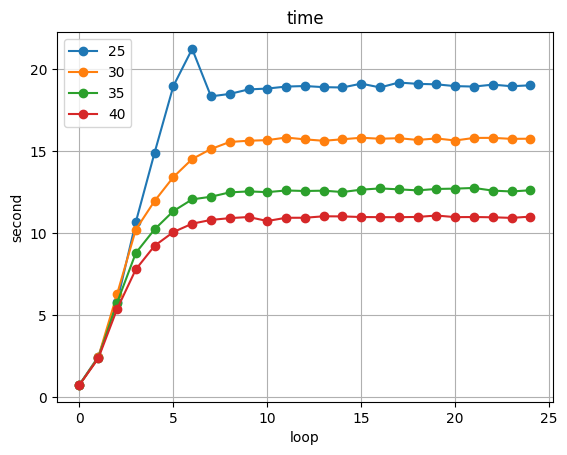

In [106]:
plt.title('time')
for threshold in [25, 30, 35, 40]:
    plt.plot([i for i in range(n)], time_dict[threshold], marker='o',label=f'{threshold}')
    # core_papers_dict[threshold]
    # inter_papers_dict[threshold]
    # scisci_ratio_dict[threshold]
plt.xlabel('loop')
plt.ylabel('second')
plt.grid()
plt.legend()

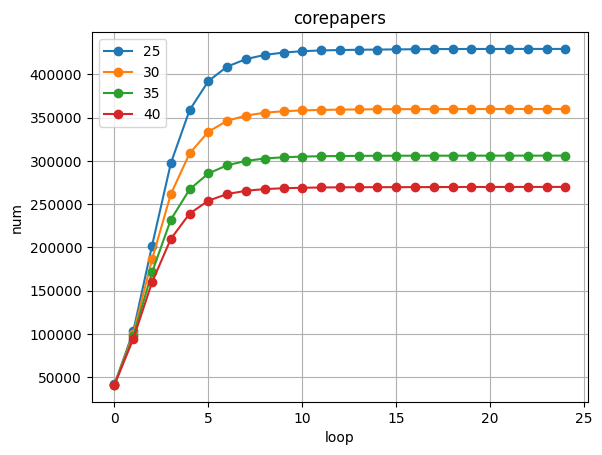

In [103]:
plt.title('corepapers')
for threshold in [25, 30, 35, 40]:
    plt.plot([i for i in range(n)], core_papers_dict[threshold], marker='o',label=f'{threshold}')
    # core_papers_dict[threshold]
    # inter_papers_dict[threshold]
    # scisci_ratio_dict[threshold]
plt.xlabel('loop')
plt.ylabel('num')
plt.legend()
plt.grid()

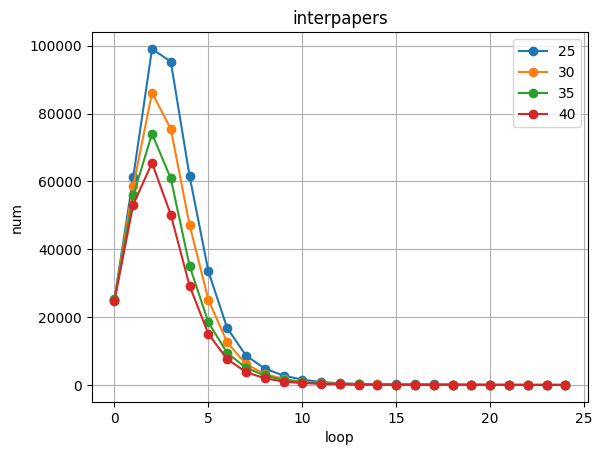

In [104]:
plt.title('interpapers')
for threshold in [25, 30, 35, 40]:
    plt.plot([i for i in range(n)], inter_papers_dict[threshold], marker='o',label=f'{threshold}')
    # core_papers_dict[threshold]
    # inter_papers_dict[threshold]
    # scisci_ratio_dict[threshold]
plt.xlabel('loop')
plt.ylabel('num')
plt.legend()
plt.grid()

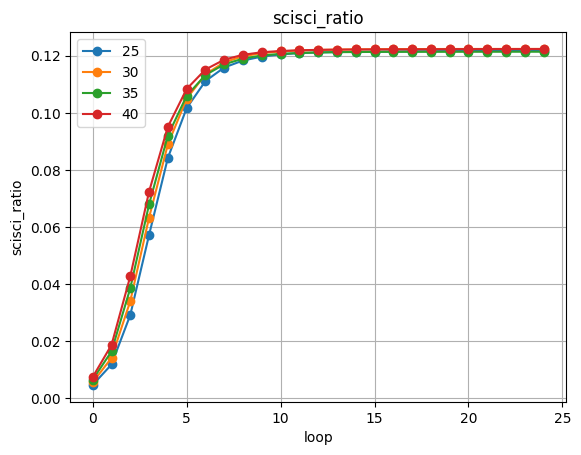

In [105]:
plt.title('scisci_ratio')
for threshold in [25, 30, 35, 40]:
    plt.plot([i for i in range(n)], scisci_ratio_dict[threshold], marker='o',label=f'{threshold}')
    # core_papers_dict[threshold]
    # inter_papers_dict[threshold]
    # scisci_ratio_dict[threshold]
plt.xlabel('loop')
plt.ylabel('scisci_ratio')
plt.legend()
plt.grid()

### 中身の確認

In [33]:
papers_data = pd.concat([
  pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/eid.pickle'),
  pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/num_cited.pickle'),
  pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/doi.pickle'),
  pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/title.pickle'),
  pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/journal.pickle'), 
  # pd.read_pickle('/disks/qnap3/shared/scopus-22/data/paper_detail/authids.pickle'),
  pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/year.pickle'),
], axis = "columns")
print(papers_data.head())

papers_data = papers_data[papers_data["doi"]!="NO DOI"]
papers_data = papers_data[papers_data["journal"]!=0]

     eid  num_cited                                                doi  \
107  107         12    10.1175/1520-0442(1997)010<2184:ASAIUF>2.0.CO;2   
110  110          6                                  10.1063/1.1285965   
116  116         32                            10.1103/PhysRevE.56.623   
117  117         84                                     10.1086/304826   
118  118         55  10.1002/(SICI)1521-4109(199907)11:9<623::AID-E...   

                                                 title      journal  year  
107  Assessing surface-atmosphere interactions usin...        13550  1997  
110  Symmetry of quantum phase space in a degenerat...        27430  2000  
116  Friction in strongly confined polymer melts: E...  21100855841  1997  
117  Nearby young dwarf galaxies: Primordial gas an...        26765  1997  
118  Determination of iodate in salt samples with a...        23979  1999  


In [113]:
target_journal =  [21100838541, # Nature Human Behaviour
  19700182758, # Nature Communications
  23571, # Science
  21121, #PNAS
  21206 #Nature
]

target_papers_subset = papers[papers["journal"].isin(target_journal)].fillna(0)
target_papers_eid = set(target_papers_subset.index)

target_papers_eid = (target_papers_eid & core_papers)

In [114]:
print('一流総合誌', len(target_papers_eid))

一流総合誌 731


In [119]:
papers_data.loc[list(target_papers_eid)[10:30]] 

,eid,num_cited,doi,title,journal,year
85044400165,85044400165,47,10.1073/pnas.1719792115,Measuring discursive influence across scholarship,21121,2018
84928383020,84928383020,154,10.1126/science.aaa0185,Big names or big ideas: Do peer-review panels ...,23571,2015
37834800,37834800,13,10.1038/423606a,Sexual contacts and epidemic thresholds: Comme...,21206,2003
77950527539,77950527539,40,10.1073/pnas.0914748107,Modularity map of the network of human cell di...,21121,2010
84861052984,84861052984,260,10.1038/485298a,Replication studies: Bad copy,21206,2012
84946907193,84946907193,17,10.1038/527S58a,Comment: A well-connected world,21206,2015
85081131069,85081131069,581,10.1073/pnas.1914221117,Historical comparison of gender inequality in ...,21121,2020
85058406462,85058406462,18,10.1073/pnas.1802918115,Twin-win model: A human-centered approach to r...,21121,2018
37075009,37075009,391,10.1038/415726a,The counting house,21206,2002
85040181314,85040181314,151,10.1073/pnas.1708414115,Gender disparities in colloquium speakers at t...,21121,2018
